# Fine Tuning BERT in Python for Sentiment Classification

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# `BERT`

BERT is designed to pre-train deep bidirectional representations from an unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications.

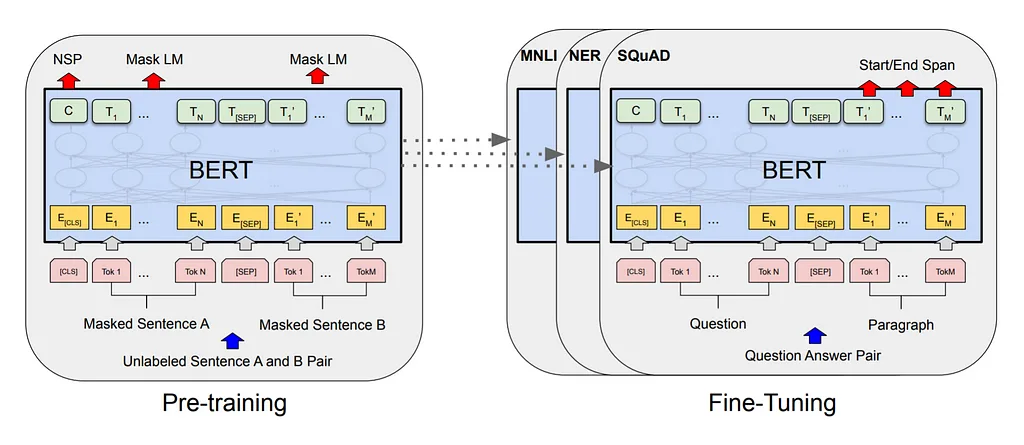

# `KTRAIN`

ktrain is a lightweight wrapper for the deep learning library TensorFlow Keras (and other libraries) to help build, train, and deploy neural networks and other machine learning models. Inspired by ML framework extensions like fastai and ludwig, it is designed to make deep learning and AI more accessible and easier to apply for both newcomers and experienced practitioners.

## Key Points to Remember

- BERT is basically a trained Transformer Encoder stack, with twelve in the Base version, and twenty-four in the Large version, compared to 6 encoder layers in the original Transformer.
- BERT encoders have larger feedforward networks (768 and 1024 nodes in Base and Large respectively) and more attention heads (12 and 16 respectively). BERT was trained on Wikipedia and Book Corpus, a dataset containing +10,000 books of different genres.

# Sentiment Classifications

In [3]:
import pandas as pd
import numpy as np

import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam

# Download Data

In [4]:
tweet = pd.read_csv('/content/drive/MyDrive/Data/mytest.csv')

In [5]:
tweet.head()

,Sentiment,text,target
0,delighted,friendly and fast transaction,4
1,disappointed,the problem was not solved in the end,1
2,neutral,conscientiously clarify our concerns at th...,2
3,delighted,everything worked very well from az fr...,4
4,disappointed,i would have liked that my complaint is ha...,1


In [6]:
tweet.shape

(15573, 3)

In [7]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15573 entries, 0 to 15572
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  15573 non-null  object
 1   text       15573 non-null  object
 2   target     15573 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 365.1+ KB


# Exploratory Data Analysis

### Target Class Distribution

In [8]:
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 80

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Emotions')

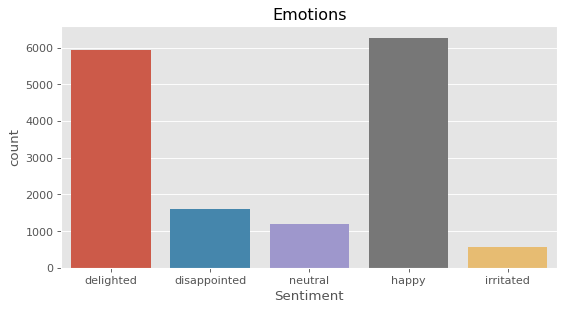

In [9]:
sns.countplot('Sentiment', data=tweet)
plt.title('Emotions')

In [10]:
tweet['Sentiment'].value_counts()

happy           6271
delighted       5929
disappointed    1612
neutral         1187
irritated        574
Name: Sentiment, dtype: int64

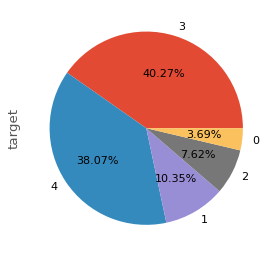

In [11]:
tweet['target'].value_counts().plot.pie(autopct='%1.2f%%')

### Number of Characters Distribution in Tweets

In [ ]:
#!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git

In [12]:
import preprocess_kgptalkie as kgp

In [13]:
tweet = kgp.get_basic_features(tweet)

In [14]:
tweet.head()

,Sentiment,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,delighted,friendly and fast transaction,4,26,4,6.500,1,0,0,0,0
1,disappointed,the problem was not solved in the end,1,30,8,3.750,5,0,0,0,0
2,neutral,conscientiously clarify our concerns at th...,2,53,8,6.625,3,0,0,0,0
3,delighted,everything worked very well from az fr...,4,68,17,4.000,11,0,0,0,0
4,disappointed,i would have liked that my complaint is ha...,1,222,48,4.625,31,0,0,0,0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


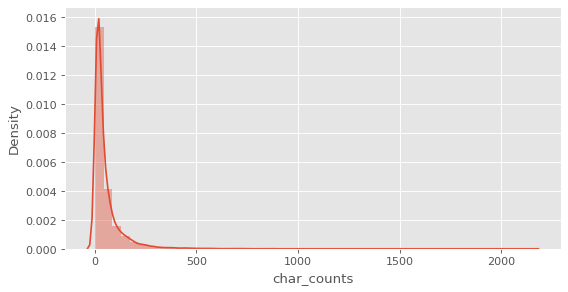

In [16]:
sns.distplot(tweet['char_counts'])

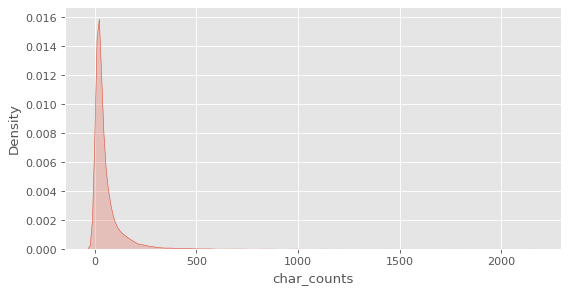

In [17]:
sns.kdeplot(tweet['char_counts'], shade=True)

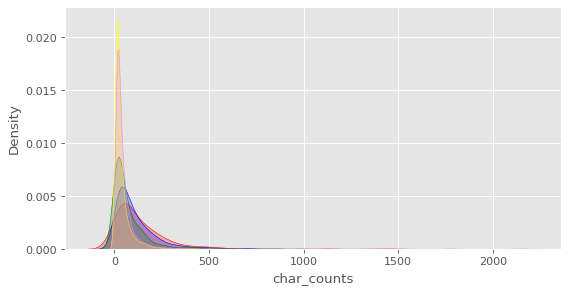

In [18]:
sns.kdeplot(tweet[tweet['target']==0]['char_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==1]['char_counts'], shade=True, color='blue')
sns.kdeplot(tweet[tweet['target']==2]['char_counts'], shade=True, color='green')
sns.kdeplot(tweet[tweet['target']==3]['char_counts'], shade=True, color='yellow')
sns.kdeplot(tweet[tweet['target']==4]['char_counts'], shade=True, color='violet')

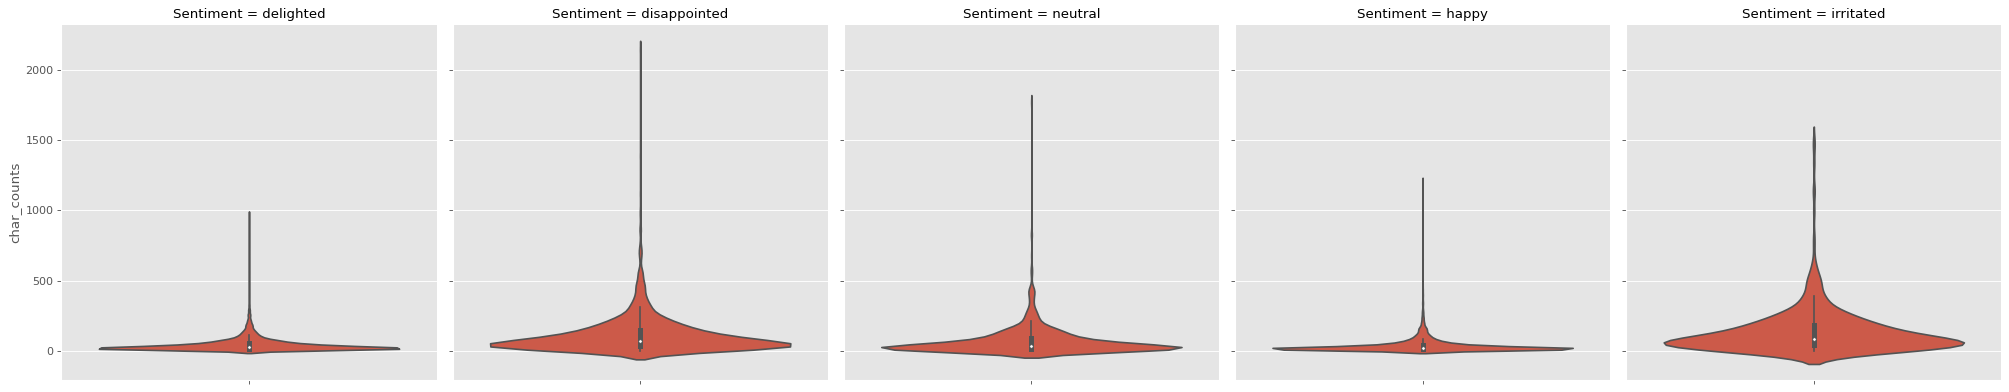

In [19]:
sns.catplot(y='char_counts', data=tweet, kind='violin', col='Sentiment')

### Number of Words, Average Words Length, and Stop words Distribution in Tweets

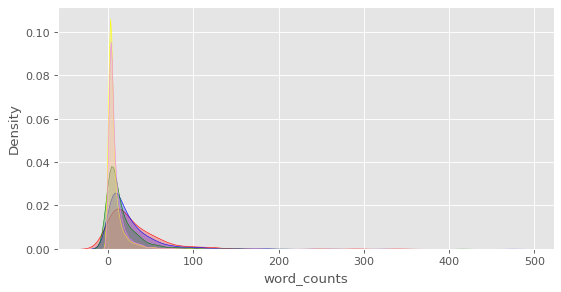

In [20]:
sns.kdeplot(tweet[tweet['target']==0]['word_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==1]['word_counts'], shade=True, color='blue')
sns.kdeplot(tweet[tweet['target']==2]['word_counts'], shade=True, color='green')
sns.kdeplot(tweet[tweet['target']==3]['word_counts'], shade=True, color='yellow')
sns.kdeplot(tweet[tweet['target']==4]['word_counts'], shade=True, color='violet')

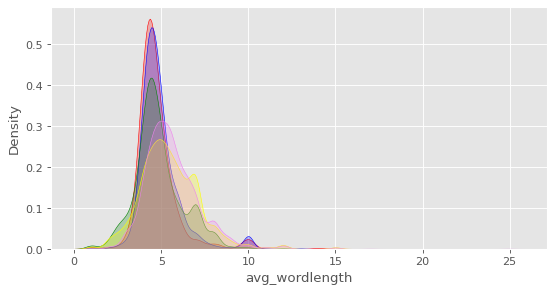

In [21]:
sns.kdeplot(tweet[tweet['target']==0]['avg_wordlength'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==1]['avg_wordlength'], shade=True, color='blue')
sns.kdeplot(tweet[tweet['target']==2]['avg_wordlength'], shade=True, color='green')
sns.kdeplot(tweet[tweet['target']==3]['avg_wordlength'], shade=True, color='yellow')
sns.kdeplot(tweet[tweet['target']==4]['avg_wordlength'], shade=True, color='violet')


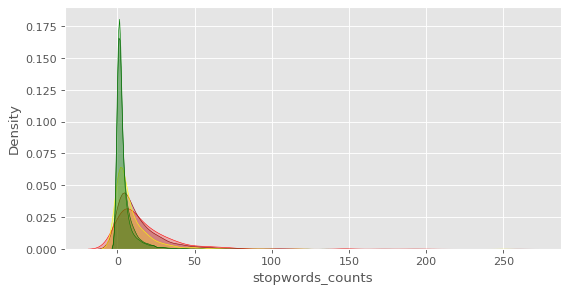

In [22]:
sns.kdeplot(tweet[tweet['target']==0]['stopwords_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==1]['stopwords_counts'], shade=True, color='darkred')
sns.kdeplot(tweet[tweet['target']==2]['stopwords_counts'], shade=True, color='yellow')
sns.kdeplot(tweet[tweet['target']==3]['stopwords_counts'], shade=True, color='green')
sns.kdeplot(tweet[tweet['target']==4]['stopwords_counts'], shade=True, color='darkgreen')


In [23]:
tweet.columns

Index(['Sentiment', 'text', 'target', 'char_counts', 'word_counts',
       'avg_wordlength', 'stopwords_counts', 'hashtag_counts',
       'mentions_counts', 'digits_counts', 'uppercase_counts'],
      dtype='object')

### Most and Least Common Words

In [24]:
freqs = kgp.get_word_freqs(tweet, 'text')

In [25]:
top20 = freqs[100:120]

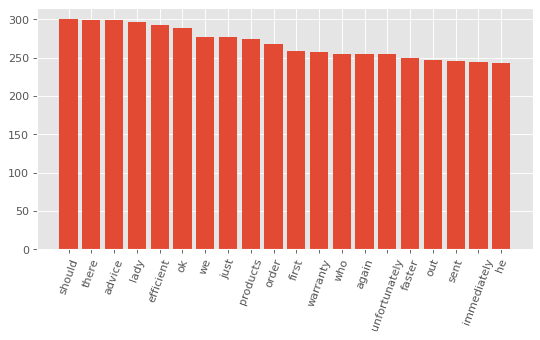

In [26]:
plt.bar(top20.index, top20.values)
plt.xticks(rotation=70)
plt.show()

In [27]:
least20 = freqs[-20:]
least20

range?                 1
350chf                 1
sm7683                 1
cristina               1
help?                  1
clogging               1
fishwick@btinternet    1
voigt                  1
mop                    1
substituted            1
sobering               1
grease                 1
effectiveness          1
console                1
conversationalist      1
airfryer?              1
circuited              1
vira                   1
topper                 1
betater                1
dtype: int64

In [28]:
bigram = kgp.get_ngram(tweet, 'text', ngram_range=2)

In [29]:
bigram[-20:]

[('000 kroner', 19),
 ('000 clicks', 18),
 ('00 when', 17),
 ('00 was', 16),
 ('00 totally', 15),
 ('00 still', 14),
 ('00 only', 13),
 ('00 made', 12),
 ('00 look', 11),
 ('00 it', 10),
 ('00 is', 9),
 ('00 incl', 8),
 ('00 for', 7),
 ('00 euros', 6),
 ('00 euro', 5),
 ('00 eur', 4),
 ('00 clock', 3),
 ('00 but', 2),
 ('00 and', 1),
 ('00 although', 0)]

### One-Shot Data Cleaning

In [30]:
def get_clean(x):
    x = str(x).lower().replace('\\', ' ').replace('_', ' ').replace('.', ' ')
    x = kgp.cont_exp(x)
    x = kgp.remove_emails(x)
    x = kgp.remove_urls(x)
    x = kgp.remove_html_tags(x)
    x = kgp.remove_rt(x)
    x = kgp.remove_accented_chars(x)
    x = kgp.remove_special_chars(x)
    x = kgp.remove_dups_char(x)
    return x

In [ ]:
tweet['text'] = tweet['text'].apply(lambda x: get_clean(x))

In [31]:
tweet.head()['text']

0                        friendly and fast transaction
1               the problem was not solved in the end 
2        conscientiously clarify our concerns at th...
3        everything worked very well from az     fr...
4        i would have liked that my complaint is ha...
Name: text, dtype: object

In [ ]:
# kgp.get_ngram(tweet, 'text', ngram_range=2)

### Disaster Words Visualization with Word Cloud



In [32]:
real = kgp.get_word_freqs(tweet[tweet['target']==1], 'text')
real = ' '.join(real.index)
real

'the i to a not and was that for my have of it in is you with me on be no customer but product service would as this answer from philips your more very had an problem can by could do at so only spare been should after device has part if new get which did buy warranty because about are still or when just time then parts will one toothbrush question products there also unfortunately now better help replacement machine we bought contact they even solution received all what send got sent repair does back than purchase again out first mail request everything offer order since years 2 3 instead were case make information know goodwill already asked like discount any find faster long take am another too good disappointing email where use without give offered wanted days old solve over available online nothing months call promised coffee up told questions possible disappointed feedback how 1 phone company times iron longer respond i\'m work e their weeks wrong who answered friendly defective u

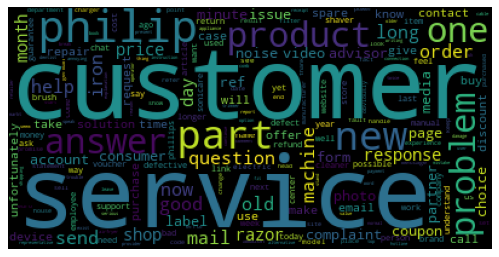

In [33]:
word_cloud = WordCloud(max_font_size=100).generate(real)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

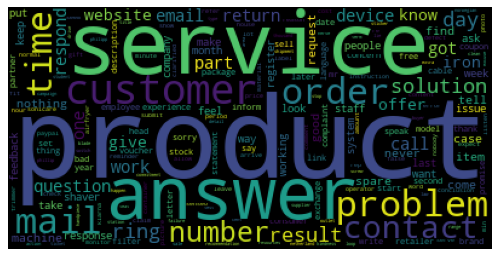

In [34]:
nreal = kgp.get_word_freqs(tweet[tweet['target']==0], 'text')
nreal = ' '.join(nreal.index)
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

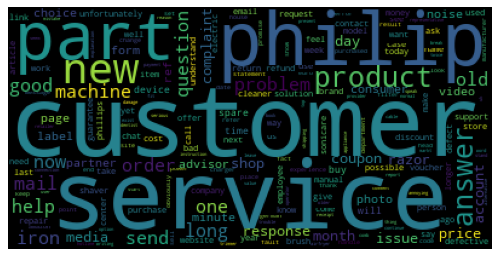

In [35]:
nreal = kgp.get_word_freqs(tweet[tweet['target']==1], 'text')
nreal = ' '.join(nreal.index)
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

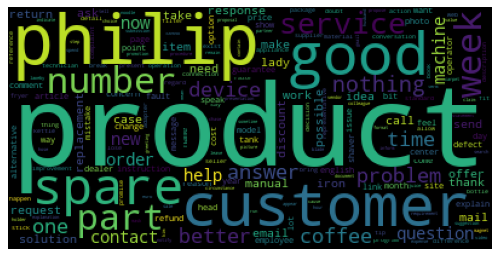

In [36]:
nreal = kgp.get_word_freqs(tweet[tweet['target']==2], 'text')
nreal = ' '.join(nreal.index)
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

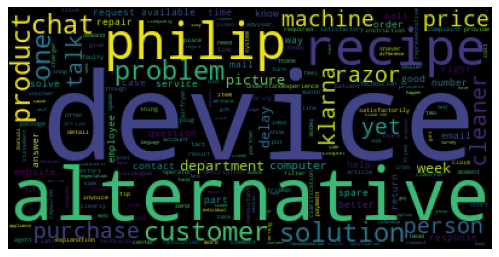

In [37]:
nreal = kgp.get_word_freqs(tweet[tweet['target']==3], 'text')
nreal = ' '.join(nreal.index)
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

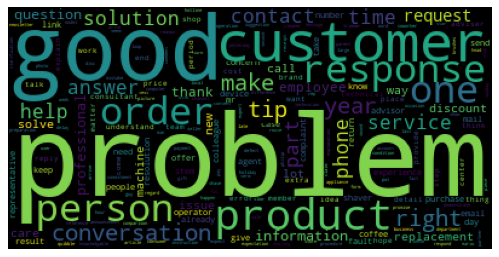

In [38]:
nreal = kgp.get_word_freqs(tweet[tweet['target']==4], 'text')
nreal = ' '.join(nreal.index)
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

## Classification with TFIDF and SVM


In [39]:
text = tweet['text']
y = tweet['target']

In [40]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

In [41]:
X.shape

(15573, 7227)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [43]:
def run_SVM(clf, X_train, X_test, y_train, y_test):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  print()
  print('Classification Report')
  print(classification_report(y_test, y_pred))

In [44]:
from sklearn.svm import LinearSVC

In [45]:
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.25      0.08      0.12       115
           1       0.45      0.43      0.44       323
           2       0.15      0.05      0.08       237
           3       0.53      0.58      0.55      1254
           4       0.62      0.68      0.65      1186

    accuracy                           0.55      3115
   macro avg       0.40      0.37      0.37      3115
weighted avg       0.52      0.55      0.53      3115



## Classification with `Word2Vec` and SVM


In [ ]:
#!python -m spacy download en_core_web_lg

In [46]:
import spacy
import en_core_web_lg

In [47]:
nlp = en_core_web_lg.load()

In [48]:
x = 'cat dog'
doc = nlp(x)

In [49]:
doc.vector.shape

(300,)

In [50]:
def get_vec(x):
  doc = nlp(x)
  vec = doc.vector
  return vec

In [51]:
tweet['vec'] = tweet['text'].apply(lambda x: get_vec(x))

In [52]:
tweet.head()

,Sentiment,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec
0,delighted,friendly and fast transaction,4,26,4,6.500,1,0,0,0,0,"[-0.24161774, 0.149732, -0.39846, -0.02886726,..."
1,disappointed,the problem was not solved in the end,1,30,8,3.750,5,0,0,0,0,"[0.04916878, 0.17309445, -0.113397785, -0.1563..."
2,neutral,conscientiously clarify our concerns at th...,2,53,8,6.625,3,0,0,0,0,"[-0.015450999, 0.019332327, -0.21864833, 0.175..."
3,delighted,everything worked very well from az fr...,4,68,17,4.000,11,0,0,0,0,"[-0.048123926, 0.10131317, -0.169872, 0.060855..."
4,disappointed,i would have liked that my complaint is ha...,1,222,48,4.625,31,0,0,0,0,"[-0.022363164, 0.12445234, -0.17742252, -0.076..."


In [53]:
X = tweet['vec'].to_numpy()
X = X.reshape(-1, 1)

In [54]:
X.shape

(15573, 1)

In [55]:
X = np.concatenate(np.concatenate(X, axis=0), axis=0).reshape(-1, 300)

In [56]:
X.shape

(15573, 300)

In [57]:
y = tweet['target']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [59]:
%%time
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.18      0.03      0.05       115
           1       0.45      0.46      0.46       323
           2       0.18      0.02      0.03       237
           3       0.50      0.53      0.52      1254
           4       0.58      0.69      0.63      1186

    accuracy                           0.53      3115
   macro avg       0.38      0.35      0.34      3115
weighted avg       0.49      0.53      0.50      3115

CPU times: user 49.5 s, sys: 67.3 ms, total: 49.6 s
Wall time: 49.6 s


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Word Embeddings and Classification with Deep Learning


In [60]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D 

In [61]:
text

0                            friendly and fast transaction
1                   the problem was not solved in the end 
2            conscientiously clarify our concerns at th...
3            everything worked very well from az     fr...
4            i would have liked that my complaint is ha...
                               ...                        
15568    you're in no way  i asked about a product that...
15569    you're in no way  i just got the service i wan...
15570                                            you're ok
15571    zoe was very good  listened to my problem and ...
15572                              zoi was really helpful 
Name: text, Length: 15573, dtype: object

In [62]:
token = Tokenizer()
token.fit_on_texts(text)

In [63]:
vocab_size = len(token.word_index) + 1
vocab_size

7373

In [64]:
print(token.word_index)

{'the': 1, 'and': 2, 'i': 3, 'to': 4, 'was': 5, 'a': 6, 'very': 7, 'my': 8, 'not': 9, 'service': 10, 'of': 11, 'it': 12, 'friendly': 13, 'for': 14, 'in': 15, 'that': 16, 'with': 17, 'have': 18, 'is': 19, 'me': 20, 'problem': 21, 'you': 22, 'good': 23, 'helpful': 24, 'customer': 25, 'on': 26, 'competent': 27, 'fast': 28, 'nothing': 29, 'answer': 30, 'be': 31, 'but': 32, 'product': 33, 'had': 34, 'no': 35, 'because': 36, 'help': 37, 'your': 38, 'as': 39, 'everything': 40, 'could': 41, 'an': 42, 'quick': 43, 'would': 44, 'nice': 45, 'do': 46, 'from': 47, 'philips': 48, 'all': 49, 'this': 50, 'has': 51, 'got': 52, 'so': 53, 'time': 54, 'more': 55, 'by': 56, 'solved': 57, 'been': 58, 'at': 59, 'question': 60, 'part': 61, 'answered': 62, 'quickly': 63, 'solution': 64, 'can': 65, 'if': 66, 'were': 67, 'response': 68, 'spare': 69, 'contact': 70, 'after': 71, 'did': 72, 'which': 73, 'information': 74, 'about': 75, 'they': 76, 'get': 77, 'great': 78, 'staff': 79, 'when': 80, 'know': 81, 'phone':

In [65]:
encoded_text = token.texts_to_sequences(text)

In [66]:
print(encoded_text)

[[13, 2, 28, 793], [1, 21, 5, 9, 57, 15, 1, 411], [3798, 836, 255, 346, 59, 1, 726, 70], [40, 250, 7, 97, 47, 3799, 47, 6, 163, 132, 4, 2886, 215, 177, 22, 7, 198], [3, 44, 18, 658, 16, 8, 301, 19, 563, 55, 3800, 2, 16, 1, 329, 14, 38, 292, 95, 96, 690, 119, 2, 9, 85, 1085, 36, 66, 22, 18, 293, 289, 538, 22, 65, 9, 189, 283, 14, 6, 403, 53, 22, 100, 912, 4, 1, 1367], [12, 368, 691], [55, 4, 913, 1, 498, 1200, 1132, 224, 69, 124, 112, 38, 874, 19, 108, 140, 1043, 3801, 480], [10, 106, 32, 1, 659, 14, 1, 530, 19, 6, 33, 530, 6, 564, 16, 22, 18, 4, 553, 14, 1, 98, 61, 837], [114, 12, 19, 108, 62, 17, 565, 133, 14, 38, 794, 11, 616, 22, 18, 241, 1044, 2, 3802, 1, 3803, 11, 8, 554, 5, 15, 8, 746, 114, 9, 137, 337, 114, 2887, 2, 2420, 222, 1852, 2, 1, 1461, 19, 747, 1269], [107, 125, 18, 1, 2888, 98, 88, 2, 55, 142, 99, 202, 748, 16, 76, 34, 692, 107, 18, 9, 84], [97, 1, 30, 72, 9, 37, 20, 198, 3, 256, 42, 1560, 14, 1, 1561, 2, 1, 25, 10, 2109, 20, 6, 995, 11, 6, 1561, 1560, 579, 92, 46, 3, 

In [67]:
max_length = 40
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [68]:
print(X)

[[  13    2   28 ...    0    0    0]
 [   1   21    5 ...    0    0    0]
 [3798  836  255 ...    0    0    0]
 ...
 [2352  106    0 ...    0    0    0]
 [7371    5    7 ...    0    0    0]
 [1919    5  137 ...    0    0    0]]


In [69]:
X.shape

(15573, 40)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [71]:
%%time
# clf = LinearSVC()
# run_SVM(clf, X_train, X_test, y_train, y_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [72]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

In [73]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 100)           737300    
_________________________________________________________________
conv1d (Conv1D)              (None, 39, 32)            6432      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 32)            0         
_________________________________________________________________
dense (Dense)                (None, 19, 32)            1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 19, 16)            5

In [74]:
%%time
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
390/390 [==============================] - 7s 10ms/step - loss: -52025.0402 - accuracy: 0.1012 - val_loss: -1673104.2500 - val_accuracy: 0.1037
Epoch 2/5
390/390 [==============================] - 4s 9ms/step - loss: -14092840.6937 - accuracy: 0.1051 - val_loss: -81770952.0000 - val_accuracy: 0.1037
Epoch 3/5
390/390 [==============================] - 4s 9ms/step - loss: -252603970.7826 - accuracy: 0.1014 - val_loss: -639914240.0000 - val_accuracy: 0.1037
Epoch 4/5
390/390 [==============================] - 4s 10ms/step - loss: -1465279127.4066 - accuracy: 0.1031 - val_loss: -2517843456.0000 - val_accuracy: 0.1037
Epoch 5/5
390/390 [==============================] - 4s 9ms/step - loss: -5054802352.7775 - accuracy: 0.1060 - val_loss: -6923554304.0000 - val_accuracy: 0.1037
CPU times: user 37.7 s, sys: 4.78 s, total: 42.4 s
Wall time: 21.8 s


In [75]:
def get_encoded(x):
  x = get_clean(x)
  x = token.texts_to_sequences([x])
  x = pad_sequences(x, maxlen=max_length, padding='post')
  return x

In [76]:
x = 'i am thrilled to see this'
vec = get_encoded(x)

In [77]:
vec

array([[   3,  136, 1548,    4,  451,   50,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]], dtype=int32)

In [78]:
np.argmax(model.predict(vec), axis = -1)

array([0])

# BERT Model Building and Training

In [ ]:
!pip install ktrain

In [79]:
tweet.head()

,Sentiment,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec
0,delighted,friendly and fast transaction,4,26,4,6.500,1,0,0,0,0,"[-0.24161774, 0.149732, -0.39846, -0.02886726,..."
1,disappointed,the problem was not solved in the end,1,30,8,3.750,5,0,0,0,0,"[0.04916878, 0.17309445, -0.113397785, -0.1563..."
2,neutral,conscientiously clarify our concerns at th...,2,53,8,6.625,3,0,0,0,0,"[-0.015450999, 0.019332327, -0.21864833, 0.175..."
3,delighted,everything worked very well from az fr...,4,68,17,4.000,11,0,0,0,0,"[-0.048123926, 0.10131317, -0.169872, 0.060855..."
4,disappointed,i would have liked that my complaint is ha...,1,222,48,4.625,31,0,0,0,0,"[-0.022363164, 0.12445234, -0.17742252, -0.076..."


In [80]:
from ktrain import text
import ktrain

In [81]:
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df=tweet, text_column='text', label_columns='target', maxlen=40, preprocess_mode='bert')

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [82]:
model = text.text_classifier(name='bert', train_data=(X_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 40
done.


In [83]:
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train), val_data=(X_test, y_test), batch_size=64)

In [84]:
learner.fit_onecycle(lr = 2e-5, epochs=1)



begin training using onecycle policy with max lr of 2e-05...
219/219 [==============================] - 86s 306ms/step - loss: 1.2502 - accuracy: 0.4640 - val_loss: 0.9634 - val_accuracy: 0.5610


In [85]:
learner.fit_onecycle(lr = 2e-5, epochs=3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
219/219 [==============================] - 62s 283ms/step - loss: 0.9269 - accuracy: 0.5898 - val_loss: 0.9429 - val_accuracy: 0.5809
Epoch 2/3
219/219 [==============================] - 62s 283ms/step - loss: 0.8897 - accuracy: 0.6059 - val_loss: 0.9441 - val_accuracy: 0.5597
Epoch 3/3
219/219 [==============================] - 62s 283ms/step - loss: 0.7889 - accuracy: 0.6536 - val_loss: 0.9302 - val_accuracy: 0.5854


In [86]:
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train), val_data=(X_test, y_test), batch_size=64)
learner.fit_onecycle(lr = 2e-4, epochs=3)



begin training using onecycle policy with max lr of 0.0002...
Epoch 1/3
219/219 [==============================] - 62s 283ms/step - loss: 0.8560 - accuracy: 0.6198 - val_loss: 0.9543 - val_accuracy: 0.5584
Epoch 2/3
219/219 [==============================] - 62s 283ms/step - loss: 0.8891 - accuracy: 0.6029 - val_loss: 0.9484 - val_accuracy: 0.5815
Epoch 3/3
219/219 [==============================] - 62s 284ms/step - loss: 0.6785 - accuracy: 0.7050 - val_loss: 1.0406 - val_accuracy: 0.5648


In [ ]:
# find out best learning rate?
# learner.lr_find()
# learner.lr_plot()

# it may take days or many days to find out.

In [87]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [88]:
data = ['i met you today by accident', 'i got today car accident, i am injured']

In [89]:
predictor.predict(data, return_proba=True)

/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:216: UserWarning: List or array of two texts supplied, so task being treated as text classification. If this is a sentence pair classification task, please cast to tuple.
  'If this is a sentence pair classification task, please cast to tuple.')


array([[1.9086910e-04, 1.5292286e-03, 9.7307755e-04, 4.3818556e-02,
        9.5348829e-01],
       [1.0198089e-01, 5.4924041e-01, 3.0316427e-01, 1.5339897e-02,
        3.0274462e-02]], dtype=float32)

In [90]:
predictor.predict(data[1])

'target_1'

In [91]:
classes = predictor.get_classes()

In [92]:
data

['i met you today by accident', 'i got today car accident, i am injured']

In [93]:
y_pred = predictor.predict(data[1])
classes.index(y_pred)

1

In [94]:
y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [95]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [97]:
data = ['completely waste of time',
        'very satisfied! thanx',
        'highly skilled person, could not be better',
        'faster service! still waiting for a cheque to be issued! use royal mail tracking instead of just blaming them. better staff that actually deal with the issue instead of just parming you off! better wording of emails',
        'great help ',
        'i was given a replacement toothbrush handle as mine had stopped working properly so that is why i am happy', 
        'very bad manners agent was rude shouted at me']

In [98]:
predictor.predict(data)

['target_1',
 'target_4',
 'target_4',
 'target_1',
 'target_4',
 'target_3',
 'target_1']

In [99]:
predictor.predict(data, return_proba=True)

array([[1.6654946e-01, 8.2194442e-01, 3.4662555e-03, 1.2028667e-03,
        6.8369582e-03],
       [2.6933113e-04, 8.8563084e-04, 1.0057295e-03, 2.4306791e-01,
        7.5477141e-01],
       [1.6251278e-04, 7.7146426e-04, 1.8544195e-03, 2.9092291e-01,
        7.0628870e-01],
       [1.0744189e-01, 8.1701124e-01, 4.7772147e-02, 2.2520784e-02,
        5.2539892e-03],
       [1.2816212e-04, 5.4672721e-04, 6.4569735e-04, 2.8305417e-01,
        7.1562529e-01],
       [2.0768856e-04, 7.7453576e-04, 1.3138894e-02, 6.2568104e-01,
        3.6019787e-01],
       [1.6608545e-01, 4.3586668e-01, 3.0647898e-03, 7.4416781e-03,
        3.8754132e-01]], dtype=float32)

In [100]:
predictor.get_classes()

['target_0', 'target_1', 'target_2', 'target_3', 'target_4']

In [102]:
predictor.save('/content/drive/MyDrive/Data/bertTP')

In [105]:
!zip -r /content/drive/MyDrive/Data/bertTP/bert.zip /content/drive/MyDrive/Data/bertTP

  adding: content/drive/MyDrive/Data/bertTP/ (stored 0%)
  adding: content/drive/MyDrive/Data/bertTP/tf_model.h5 (deflated 19%)
  adding: content/drive/MyDrive/Data/bertTP/tf_model.preproc (deflated 52%)
  adding: content/drive/MyDrive/Data/bertTP/.ipynb_checkpoints/ (stored 0%)


In [106]:
predictor_load = ktrain.load_predictor('/content/drive/MyDrive/Data/bertTP')

In [107]:
data = ['completely waste of time',
        'very satisfied! thanx',
        'highly skilled person, could not be better',
        'faster service! still waiting for a cheque to be issued! use royal mail tracking instead of just blaming them. better staff that actually deal with the issue instead of just parming you off! better wording of emails',
        'great help ',
        'i was given a replacement toothbrush handle as mine had stopped working properly so that is why i am happy', 
        'very bad manners agent was rude shouted at me']

In [109]:
predictor_load.get_classes()

['target_0', 'target_1', 'target_2', 'target_3', 'target_4']

In [110]:
predictor_load.predict(data)

['target_1',
 'target_4',
 'target_4',
 'target_1',
 'target_4',
 'target_3',
 'target_1']

In [111]:
predictor_load.predict(data, return_proba=True)

array([[1.6654946e-01, 8.2194442e-01, 3.4662555e-03, 1.2028667e-03,
        6.8369582e-03],
       [2.6933113e-04, 8.8563084e-04, 1.0057295e-03, 2.4306791e-01,
        7.5477141e-01],
       [1.6251278e-04, 7.7146426e-04, 1.8544195e-03, 2.9092291e-01,
        7.0628870e-01],
       [1.0744189e-01, 8.1701124e-01, 4.7772147e-02, 2.2520784e-02,
        5.2539892e-03],
       [1.2816212e-04, 5.4672721e-04, 6.4569735e-04, 2.8305417e-01,
        7.1562529e-01],
       [2.0768856e-04, 7.7453576e-04, 1.3138894e-02, 6.2568104e-01,
        3.6019787e-01],
       [1.6608545e-01, 4.3586668e-01, 3.0647898e-03, 7.4416781e-03,
        3.8754132e-01]], dtype=float32)